In [1]:
# reloads modules when running again
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

from model_functions import *

from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics.pairwise import pairwise_distances

import warnings
warnings.filterwarnings('ignore')

## Data loading

In [3]:
data, metadata = load_data()

In [4]:
new_data, new_metadata = load_data(data_name="new_data", metadata_name="new_metadata")

In [5]:
# merge data
data = pd.concat([data, new_data], ignore_index=True)

## Data preprocessing

### Split to train-test

In [6]:
# sort data by collection date
data = data.sort_values(by="collection_date")
train_df = data.copy()
test_df = new_metadata[~new_metadata["sample"].isin(data["sample"])]

test_df = test_df.reset_index(drop=True)
train_df = train_df.reset_index(drop=True)

In [7]:
meta_features_union = meta_features + ["month_sin", "month_cos"]

### Aggregation

In [8]:
# aggregate to one sample per week
train_df = aggregate_samples(train_df.copy())

In [9]:
train_df["collection_date"] = pd.to_datetime(train_df["collection_date"])
taxa_columns = [col for col in train_df.columns if col not in meta_features_union]

## Train

In [10]:
x_test = test_df.copy()
x_test = x_test.reset_index()
print("start trend_pred")
trend_prediction = trend_pred(data, x_test)
trend_prediction = trend_prediction.sort_values("index").reset_index(drop=True)
trend_prediction.to_csv("trend_prediction.csv")

print("finished trend_pred\nstart seasonal_pred")
seasonal_prediction = seasonal_pred(data, x_test)
seasonal_prediction = seasonal_prediction.sort_values("index").reset_index(drop=True)
seasonal_prediction.to_csv("seasonal_prediction.csv")
print("finished seasonal_pred")

start trend_pred
finished trend_pred
start seasonal_pred
finished 100 out of 1695
finished 200 out of 1695
finished 300 out of 1695
finished 400 out of 1695
finished 500 out of 1695
finished 600 out of 1695
finished 700 out of 1695
finished 800 out of 1695
finished 900 out of 1695
finished 1000 out of 1695
finished 1100 out of 1695
finished 1200 out of 1695
finished 1300 out of 1695
finished 1400 out of 1695
finished 1500 out of 1695
finished 1600 out of 1695
finished seasonal_pred


In [ ]:
pred_df = predict(train_df, test_df)
pred_df.to_csv("pred_df.csv")

## Performance analysis

In [ ]:
# can be uncomment for loading the data from a csv file instead of running the predict function

# pred_df = pd.read_csv("pred_df.csv")

In [ ]:
# calculating Bray-Curtis score
d_matrix = pairwise_distances(pred_df[y_test.columns], y_test, metric="braycurtis").diagonal()
pd.DataFrame(d_matrix).to_csv("braycurtis_performance.csv")
braycurtis_score = d_matrix.mean()

### Performance Analysis

In [ ]:
print(f"Bray-Curtis score: {round(braycurtis_score, 5)}")

In [ ]:
analysis_df = test_df.copy()
analysis_df["braycurtis_score"] = d_matrix
analysis_df.drop(columns=["interpolated", "month_sin", "month_cos"], inplace=True)

In [12]:
# new part after milestone3
res = pd.read_csv("bc_res.csv", index_col=0)
res = res.merge(new_metadata, on="sample", how="left")
extrapolation = res[res["is_extrapolation"]]
no_extrapolation = res[~res["is_extrapolation"]]

In [13]:
analysis_df = no_extrapolation.copy()

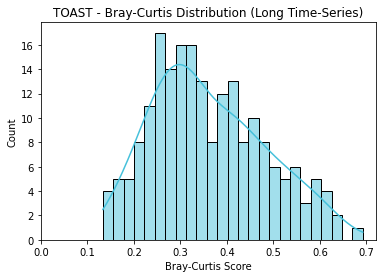

In [19]:
# Bray-Curtis Distribution
plt.grid(False)
sns.histplot(analysis_df["braycurtis_score"], color="#46c1db", bins=25, kde=True)
plt.title("TOAST - Bray-Curtis Distribution (Long Time-Series)")
plt.xlabel("Bray-Curtis Score")
plt.xlim(0)
plt.savefig("TOAST - Bray-Curtis Distribution (Long Time-Series)")
plt.show()

In [ ]:
# Bray-Curtis Distribution
plt.grid(False)
sns.histplot(analysis_df.groupby("baboon_id")[["braycurtis_score"]].agg("mean")["braycurtis_score"], color="#46c1db", bins=25, kde=True)
plt.title("Average Bray-Curtis per Baboon")
plt.xlabel("Average per Baboon")
plt.show()

In [ ]:
# Bray-Curtis by sex
plt.grid(False)
sns.violinplot(data=analysis_df, hue="sex", y="braycurtis_score", palette="muted")
plt.title("Bray-Curtis per Sex")
plt.xlabel("Sex")
plt.ylabel("Bray-Curtis Score")
plt.show()

In [ ]:
# Bray-Curtis per Baboon
plt.figure(figsize=(30, 6))
plt.grid(True)
analysis_df["baboon_mean"] = analysis_df.groupby("baboon_id")[["braycurtis_score"]].transform("median")["braycurtis_score"]
sns.violinplot(data=analysis_df.sort_values("baboon_mean"), hue="baboon_id", y="braycurtis_score", palette="muted", legend=False)
plt.title("Bray-Curtis per Baboon")
plt.xlabel("Baboon")
plt.xlim((-0.41,0.41))
plt.ylabel("Bray-Curtis Score")
plt.show()

In [16]:
# creating a dictionary of babbon_id:last known sample
d = dict()
for baboon_id in train_df["baboon_id"].unique():
    d[baboon_id] = [sorted(train_df[train_df["baboon_id"] == baboon_id]["collection_date"].to_list())[-1]]
df1 = pd.DataFrame(d).T
merged_df = analysis_df.merge(df1, left_on="baboon_id", right_index=True)

In [17]:
# computing the distance between each sample to the last one in the train dataset
merged_df.rename(columns={0:"last_timepoint"}, inplace=True)
merged_df["dist_in_days"] = 0
merged_df["dist_in_days"] = merged_df.apply(lambda row: np.abs(row["collection_date"] - row["last_timepoint"]).total_seconds() / (60 * 60 * 24), axis=1)

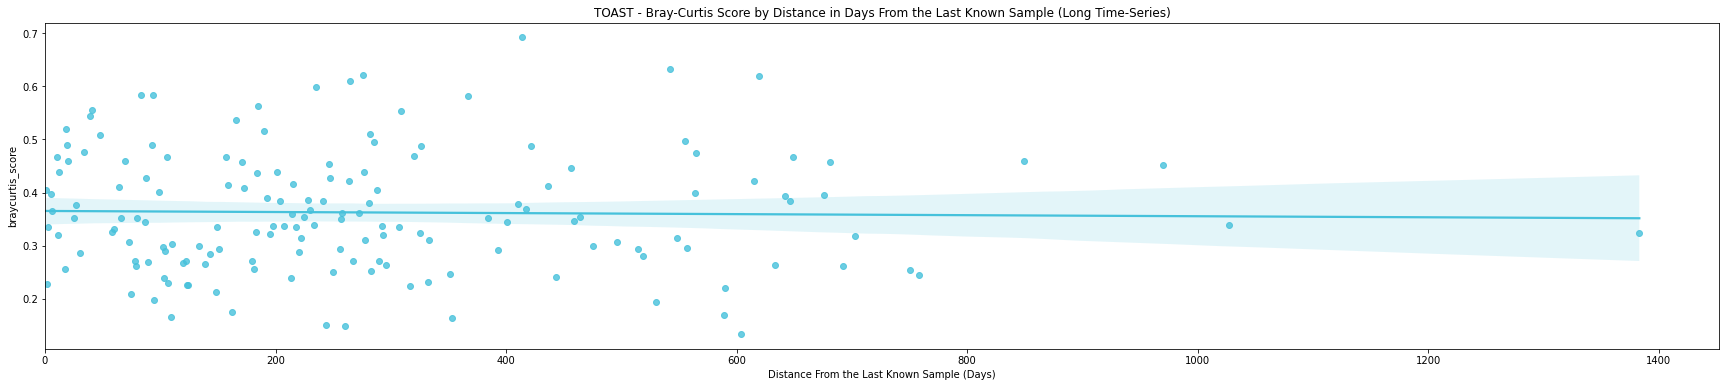

In [20]:
# plot the Bray-Curtis score for the distances in days
mean_by_dist = merged_df.groupby("dist_in_days")[["braycurtis_score"]].mean()
plt.figure(figsize=(30, 6))
sns.regplot(x=mean_by_dist.index, y=mean_by_dist["braycurtis_score"], color="#46c1db")
plt.xlabel("Distance From the Last Known Sample (Days)")
plt.title("TOAST - Bray-Curtis Score by Distance in Days From the Last Known Sample (Long Time-Series)")
#plt.xscale("log")
plt.xlim(0)
plt.savefig("TOAST - Bray-Curtis Score by Distance in Days From the Last Known Sample (Long Time-Series)")
plt.show()

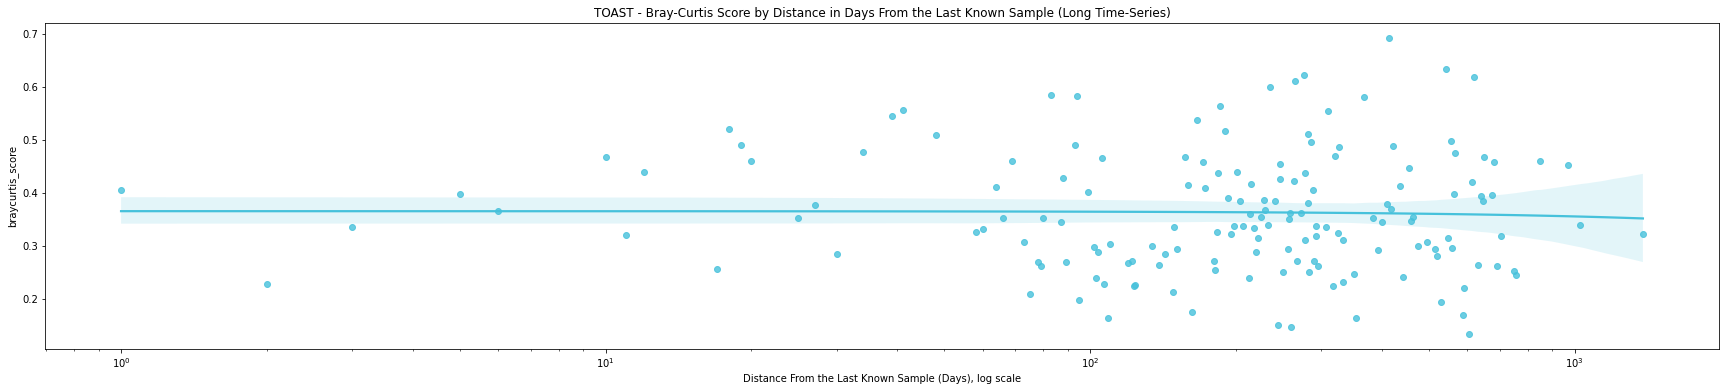

In [18]:
# plot the Bray-Curtis score for the distances in days
mean_by_dist = merged_df.groupby("dist_in_days")[["braycurtis_score"]].mean()
plt.figure(figsize=(30, 6))
sns.regplot(x=mean_by_dist.index, y=mean_by_dist["braycurtis_score"], color="#46c1db")
plt.xlabel("Distance From the Last Known Sample (Days), log scale")
plt.title("TOAST - Bray-Curtis Score by Distance in Days From the Last Known Sample (Long Time-Series)")
plt.xscale("log")
plt.xlim(0)
plt.savefig("log TOAST - Bray-Curtis Score by Distance in Days From the Last Known Sample (Long Time-Series)")
plt.show()